In [1]:
from priors import *
from container import *
from client import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from logreg import *
from SLGD import *
from preconditioners import *

# Models and dataset

A logistic regression in 2d has a posterior that can be approximated using the mean and fisher information of sampled weights.  Using this, one can demonstrate visually that the decentralized and federated langevin dynamics model samples from the correct posterior.

In [2]:
# 20,000 samples from a dataset built for classification, two seperate gaussians with different mean and variance
logrdata = LogReg(20000,2,5,1)
model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())
lr = 1e-3
n_clients = 20
batch_size = 100

models = init_clients(logrdata, n_clients, model, lr)

# Loss and Model Init

Use the BCE Loss for a logistic regression, it takes a probability (sigmoid output) and computes the nll loss

In [3]:
loss_criterion = nn.BCELoss()
distributed_models = Container(models, loss_criterion)

# Fisher matrix approx

Approximate the fisher information using the gradient calculated with the labels.  This leads to approximately the same results AT THE MINIMA ONLY.

In [4]:
def fisher(distributed_models):
    F = torch.zeros(2,2)
    count = 0
    g = 0
    with torch.no_grad():
        for client in distributed_models.clients:
            for name in client.grad:#client.model.named_parameters():
                if 'weight' in name.split('.'):
                    # takes the aggregated gradients
                    param = client.grad_no_noise[name]
                    g = param.view(-1,1)
                    F += g @ g.T

        return(F/distributed_models.b)

# Main training loop

This goes on for longer than needed in order to get enough samples to compare the sampled distribution to the laplace approximated posterior.

In [5]:
training_loss = []
F = torch.eye(2)
N = 3001
mu = 0.5

for i in range(N):
    loss = distributed_models.train(batch_size,.8)
    training_loss.append(loss.item())
    
    if i % 100 == 0:
        print('epoch: ', i, ' loss: ', loss.item())
        
    if (i >= 1000) and (i % 20 == 0):
        distributed_models.aggregate_sample()
        # exponential average of the fisher information
        #F = (1-mu)*F + mu*fisher(distributed_models)
        F = i/(i+1)*F + fisher(distributed_models)/(i+1)


epoch:  0  loss:  0.7910107374191284
epoch:  100  loss:  0.4390307366847992
epoch:  200  loss:  0.4341496527194977
epoch:  300  loss:  0.4210048317909241
epoch:  400  loss:  0.43006807565689087
epoch:  500  loss:  0.41633516550064087
epoch:  600  loss:  0.4278683662414551
epoch:  700  loss:  0.41570597887039185
epoch:  800  loss:  0.41247063875198364
epoch:  900  loss:  0.40596312284469604
epoch:  1000  loss:  0.4104793965816498
epoch:  1100  loss:  0.4043101370334625
epoch:  1200  loss:  0.39873212575912476
epoch:  1300  loss:  0.40128007531166077
epoch:  1400  loss:  0.4012773036956787
epoch:  1500  loss:  0.39784717559814453
epoch:  1600  loss:  0.40265917778015137
epoch:  1700  loss:  0.401017963886261
epoch:  1800  loss:  0.3991950452327728
epoch:  1900  loss:  0.4002884030342102
epoch:  2000  loss:  0.3959079682826996
epoch:  2100  loss:  0.40077918767929077
epoch:  2200  loss:  0.40481847524642944
epoch:  2300  loss:  0.4043332636356354
epoch:  2400  loss:  0.4003545641899109
ep

In [6]:
print(F)

tensor([[1.1805, 0.2015],
        [0.2015, 1.1608]])


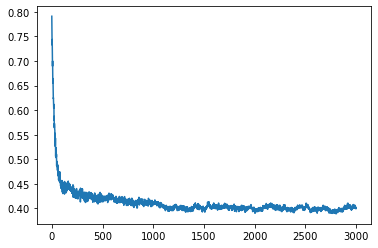

In [7]:
plt.plot(training_loss)

In [8]:
logrdata_test = LogReg(20000,2,5,1)
batch_size = 100
test_loader = DataLoader(logrdata_test, batch_size = batch_size)

def test_logistic(distributed_models, test_loader, fisher_est = False):
    if not fisher_est:
        with torch.no_grad():
            loss = []
            total = 0
            correct = 0
            for batch in test_loader:
                total += len(batch[0])
                y_i = distributed_models(batch[0])
                loss.append(loss_criterion(y_i, batch[1]))

                y_i = 1.0*(y_i >= 0.5)
                correct += torch.eq(y_i, batch[1]).sum()

            accuracy = correct / total
            avg_loss = sum(loss) / len(loss)

        return(accuracy, avg_loss)

    else:
        loss = []
        total = 0
        correct = 0
        distributed_models
        F = torch.eye(2)
        for i,batch in enumerate(test_loader):
            
            distributed_models.zero_grad()
            total += len(batch[0])
            y_i = distributed_models(batch[0])
            loss.append(loss_criterion(y_i, batch[1]))


            # estimating the fisher information requires one to calculate
            # the maximum liklihood using the labels FROM the model
            loss_f = loss_criterion(y_i, y_i)
            loss_f.backward()
            
            F_i = fisher(distributed_models)
            F = i/(i+1)*F + F_i/(i+1)
            y_i = 1.0*(y_i >= 0.5)
            correct += torch.eq(y_i, batch[1]).sum()
            
        accuracy = correct / total
        avg_loss = sum(loss) / len(loss)
        return accuracy, avg_loss, F

acc, avg_loss, F2 = test_logistic(distributed_models, test_loader, True)
print(acc, avg_loss)

tensor(0.9985) tensor(0.3854, grad_fn=<DivBackward0>)


In [9]:
print(F2)

tensor([[3.0332, 2.3268],
        [2.3268, 2.2758]])


# Easy dataset

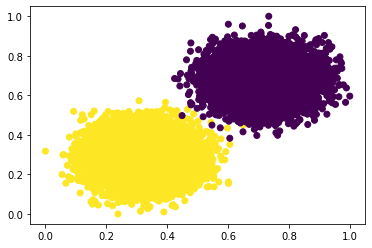

In [10]:
plt.scatter(logrdata.data[:,0].numpy(), logrdata.data[:,1].numpy(), c = logrdata.targets.numpy())

# Extract all saved weights and process them
Weights are saved both all in a list, as an overall mean, and averaged across all models at a given time

In [11]:
# Calculate the fisher information and means of weights to see sampling distr. with laplace approx

def extract_mean_weights(distributed_models):
    model = distributed_models.clients[0].model
    states = {name: 0 for name, parameter in model.named_parameters()}
    all_saved = {name: [] for name, param in model.named_parameters()}
    count = 0
    for client in distributed_models.clients:
        for saved in client.saved_weights:
            for key in saved.keys():
                count +=1
                states[key]+= saved[key]
                all_saved[key].append(saved[key])

    states = {key: states[key]/count for key in states.keys()}
    return states, all_saved

In [12]:
avg_weights = []
for i in range(len(distributed_models.clients[0].saved_weights)):
    mean_weight = 0
    for client in distributed_models.clients:
        mean_weight += client.saved_weights[i]['0.weight']
    mean_weight /= len(distributed_models.clients)
    avg_weights.append(mean_weight)

In [13]:
states, all_saved = extract_mean_weights(distributed_models)

weight_samples = torch.vstack(all_saved['0.weight']).numpy()
weight_samples_2 = torch.vstack(avg_weights).numpy()

center = states['0.weight'].numpy()[0]
center = np.mean(weight_samples, axis = 0)

In [14]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def conf_ellipse(F, center, ax, n_std = 1.0, facecolor = 'none',other=[], **kwargs):
    if len(other) == 0:
        cov = np.linalg.inv(F)
    else:
        cov = np.cov(other[:,0], other[:,1])
        
    pearson = cov[0,1]/np.sqrt(cov[0,0]*cov[1,1])
    ell_y = np.sqrt(1 - pearson)
    ell_x = np.sqrt(1 + pearson)

    ellipse = Ellipse((0, 0), width = ell_x * 2, height = ell_y * 2, facecolor = facecolor, **kwargs)
    
    scale_x = np.sqrt(cov[0,0])*n_std
    scale_y = np.sqrt(cov[1,1])*n_std
    print('info: ', scale_x, scale_y, ell_x, ell_y)

    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(center[0], center[1])
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


# Confidence ellipse shows that weights are distributed correctly.

Using the laplace approximation to the posterior, which uses the inverse fisher information as the estimate of the covariance of the model weights, we can see that the model is extracting weights appro

info:  0.1998056874023105 0.17917467802621057 0.9675589657732095 1.0314211786423029
info:  0.19820386916399002 0.19987718760967255 0.9098581308823217 1.0826625428393317


Text(0.5, 1.0, 'Sampled Points Closely Match Laplace Approximation of Posterior')

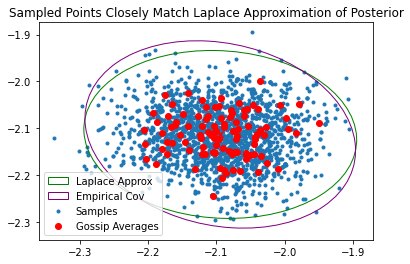

In [29]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(weight_samples[:,0], weight_samples[:,1], marker = '.', label= 'Samples')
ax.scatter(weight_samples_2[:,0], weight_samples_2[:,1], color = 'red', label = 'Gossip Averages')
center = np.mean(weight_samples, axis = 0)
ax.scatter(center[0], center[1], c = 'red', marker = 'x')
conf_ellipse(F.numpy(), center, ax, n_std = 3.0, edgecolor = 'green', other = weight_samples, label = 'Laplace Approx')

# use the training set F since it is qualitatively similar to the test set
# and matches the training data sampled weights more closely.  200 is size of samples over size of batches
conf_ellipse(F.numpy()*200, center, ax, n_std = 3.0, edgecolor = 'purple', label = 'Empirical Cov')
plt.legend()
plt.title('Sampled Points Closely Match Laplace Approximation of Posterior')

(array([  3.,  22.,  73., 207., 355., 489., 494., 269.,  85.,  23.]),
 array([-2.3381467, -2.2948794, -2.2516122, -2.208345 , -2.165078 ,
        -2.1218107, -2.0785434, -2.0352762, -1.9920089, -1.9487418,
        -1.9054745], dtype=float32),
 <BarContainer object of 10 artists>)

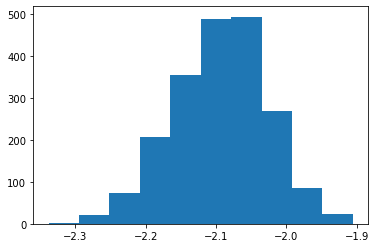

In [16]:
plt.hist(weight_samples[:,0])

(array([ 24.,  73., 199., 420., 525., 428., 261.,  76.,  12.,   2.]),
 array([-2.2956645, -2.2555902, -2.2155159, -2.1754413, -2.135367 ,
        -2.0952926, -2.0552182, -2.0151439, -1.9750694, -1.9349949,
        -1.8949206], dtype=float32),
 <BarContainer object of 10 artists>)

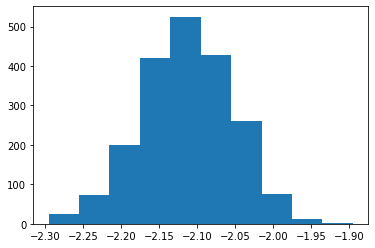

In [17]:
plt.hist(weight_samples[:,1])

# Making a cenralized model

this is for comparison

In [18]:
train_loader = DataLoader(logrdata, shuffle = True, batch_size = 100)

In [19]:
class SLR(nn.Module):
    def __init__(self):
        super(SLR, self).__init__()
        self.lin = nn.Linear(2,1)
        self.transform = nn.Sigmoid()
        self.weights = []

    def forward(self, x):
        out = self.lin(x)
        
        return self.transform(out)
    
    def sample(self):
        with torch.no_grad():
            self.weights.append({name: param.data.clone() for name, param in self.lin.named_parameters()})
    
    def fisher(self):
        g = 0
        count = 0
        F = torch.zeros(2,2)
        with torch.no_grad():
            for name, param in self.lin.named_parameters():
                if 'weight' in name:
                    if param.grad is not None:
                        g = param.grad.view(-1,1)
                        F = g @ g.T 
        return F

In [20]:
lr = .9
model = SLR()
N = 20000
optimizer = SLGD(model.parameters(), lr = lr, N = N, prior = Gaussian(0,.1), preconditioner = Euclidean)
loss_criterion = nn.BCELoss()

In [21]:
train_loss_slr = []
mu = 0.5
F_SLR = torch.eye(2)
i = 0
for epoch in range(50):
    for batch in train_loader:
        i+= 1
        optimizer.zero_grad()
        y = model(batch[0])

        loss = loss_criterion(y, batch[1])
        train_loss_slr.append(loss.detach().item())

        loss.backward()

        optimizer.step()
        
        if i >= 1000 and i % 20 == 0:
            model.sample()
            #F_SLR = (1 - mu)*F_SLR + mu*model.fisher()
            F_SLR = i/(i+1)*F_SLR + 1/(i+1)*model.fisher()
            
        if i % 100 == 0:
            print(i, loss.item())

C:\Users\bbb2193\Anaconda3\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [1, 2], strides() = [1, 1]
param.sizes() = [1, 2], strides() = [2, 1] (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch/csrc/autograd/functions/accumulate_grad.h:192.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100 0.2796097695827484
200 0.23203925788402557
300 0.22701677680015564
400 0.19399279356002808
500 0.1823844164609909
600 0.21015922725200653
700 0.19658279418945312
800 0.18226847052574158
900 0.1973302662372589
1000 0.20422333478927612
1100 0.20601573586463928
1200 0.17608051002025604
1300 0.19033263623714447
1400 0.19631019234657288
1500 0.19046899676322937
1600 0.20624925196170807
1700 0.1926610767841339
1800 0.21909207105636597
1900 0.20170260965824127
2000 0.19495771825313568
2100 0.18362383544445038
2200 0.2029830515384674
2300 0.19759315252304077
2400 0.20010973513126373
2500 0.19825586676597595
2600 0.19904011487960815
2700 0.19615192711353302
2800 0.19798360764980316
2900 0.19187384843826294
3000 0.1885984092950821
3100 0.18384046852588654
3200 0.20375075936317444
3300 0.19637510180473328
3400 0.1936752200126648
3500 0.18718881905078888
3600 0.1950632929801941
3700 0.19569016993045807
3800 0.19816356897354126
3900 0.17282424867153168
4000 0.19590447843074799
4100 0.1936691254

In [22]:
F_SLR

tensor([[8.9079e-01, 1.0152e-05],
        [1.0152e-05, 8.9079e-01]])

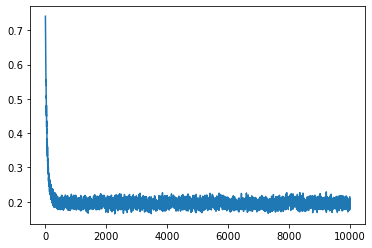

In [23]:
plt.plot(train_loss_slr)

In [24]:
saved_weights_slr = []
for weights in model.weights:
    saved_weights_slr.append(weights['weight'].data)

In [25]:
saved_weights_slr = torch.vstack(saved_weights_slr).numpy()

In [26]:
acc, loss = test_logistic(model, test_loader)

print(acc, loss)

tensor(0.9995) tensor(0.1869)


info:  0.22454926353512816 0.23060427108643833 0.7479517776270507 1.200236700965495
info:  0.22475986182689667 0.2247600182890892 0.9999943018184693 1.0000056981490617


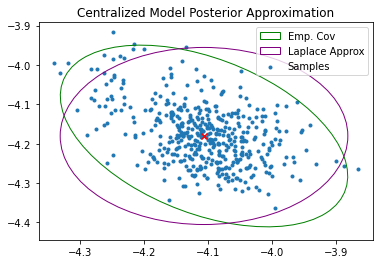

In [32]:

fig = plt.figure()
ax = plt.gca()
ax.scatter(saved_weights_slr[:,0], saved_weights_slr[:,1], marker = '.', label = 'Samples')
center = np.median(saved_weights_slr, axis = 0)
ax.scatter(center[0], center[1], c = 'red', marker = 'x')
conf_ellipse(F.numpy(), center, ax, n_std = 3.0, edgecolor = 'green', other = saved_weights_slr, label = 'Emp. Cov')

# 200 is size of samples over size of batches
conf_ellipse(F_SLR*200, center, ax, n_std = 3.0, edgecolor = 'purple', label = 'Laplace Approx')
plt.title('Centralized Model Posterior Approximation')
plt.legend()